In [25]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [26]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [27]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [28]:
X, y = mnist["data"], mnist["target"]

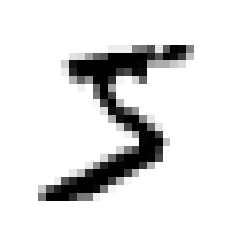

In [29]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [30]:
y = y.astype(np.uint8)

Note: we usually shuffle data sets but need to take caution when doing this with time series or causal data

In [31]:
# Normally would split this but the data set is already shuffled

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [35]:
# target vector for binary classification, only the number 5
# a boolean, equal to the test of whether a piece of data is equal to the number 5

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [36]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [37]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Stochastic gradient descent classifier

In [39]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [40]:
sgd_clf.predict([some_digit])

array([ True])

Cross-validation means splitting the training set into K folds, training the model on the k-1 folds and evaluating it on the remaining part of the data

In [42]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

A dumb classifier, using BaseEstimator which is a basic class with the methods .get_params and .set_params, which just returns 0 for all values, and so for this task is ~90% accurate since 90% of the values are predicted correctly

In [43]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)



cross_val_score uses the .predict method in the never_5_clf object

In [44]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Classifiers are better evaluated using a confusion matrix, which counts the number of times instances are incorrectly classified. We need some predictions. Why does this use cross-validation rather than computing directly?

In [45]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred_direct = sgd_clf.predict(X_train)

In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [48]:
confusion_matrix(y_train_5, y_train_pred_direct)

array([[52316,  2263],
       [  601,  4820]])

### Precision and recall

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

Precision: what proportion of the positive predictions are true positive?

Recall: of the true positives, what proportion are classified correctly?


In [49]:
# Extension - applying this to the Never5Classifier

never_5_clf = Never5Classifier()

y_train_never5_pred = never_5_clf.predict(X_train)
confusion_matrix(y_train_5, y_train_never5_pred)

array([[54579,     0],
       [ 5421,     0]])

Putting everything as false gives:
* precision = TP / (TP + FP) = 0 / (0 + 0)
* recall = TP / (TP + FN) = 0 / (0 + 5421)

In [50]:
# what if we had an always 5 classifier?

class Always5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.ones((len(X),1), dtype=bool)

In [51]:
always_5_clf = Always5Classifier()
y_train_always5_pred = always_5_clf.predict(X_train)
confusion_matrix(y_train_5, y_train_always5_pred)

array([[    0, 54579],
       [    0,  5421]])

Putting everything as true gives:
* Precision = TP / (TP + FP) = 5421 / (5421 + 54579) = 9%
* Recall = TP / (TP + FN) = 5421 / 5421 = 100%

In [55]:
from sklearn.metrics import precision_score, recall_score

print('Precision score, normal predictor :', precision_score(y_train_5, y_train_pred))
print('Recall score, normal predictor :', recall_score(y_train_5, y_train_pred))

print('Precision score, never5 predictor :', precision_score(y_train_5, y_train_never5_pred))
print('Recall score, never5 predictor :', recall_score(y_train_5, y_train_never5_pred))

print('Precision score, always5 predictor :', precision_score(y_train_5, y_train_always5_pred))
print('Recall score, always5 predictor :', recall_score(y_train_5, y_train_always5_pred))

# Warnings shown up because never5 predictor has a div by zero error

Precision score, normal predictor : 0.8370879772350012
Recall score, normal predictor : 0.6511713705958311
Precision score, never5 predictor : 0.0
Recall score, never5 predictor : 0.0
Precision score, always5 predictor : 0.09035
Recall score, always5 predictor : 1.0


/home/ben/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The trade-off between precision and recall can be shown with the .decision_function method of the classifier, where it needs to be above some value 

In [63]:
# This shows the decision threshold for the different observations, where positive means it is classified as a 5

y_scores = sgd_clf.decision_function(X_train[0:5])
print(y_scores)
print(y_train[0:5])

[  2164.22030239  -5897.37359354 -13489.14805779  -4623.84515943
  -6873.05248453]
[5 0 4 1 9]


In [64]:
# We can plot all of this using the precision and recall curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

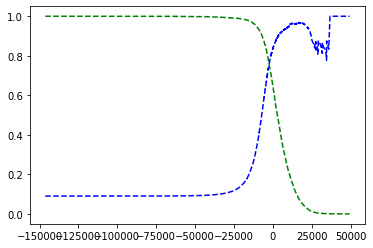

In [65]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Question to ankify: why can the precision go down when the threshold goes up?

Answer: precision = TP / (TP + FP), so if FP goes down then precision goes up, but if we fail to identify a positive, TP will go down on both top and bottom and will have a larger effect on the top so precision goes down. Generally our classifier is becoming more stringent, and precision (how many of our positives are true) can move up and down.

In [69]:
precisions.shape

(60001,)

In [77]:
A = [1,2,3,4,5,4,4]
np.argmax( A >= 4)

TypeError: '>=' not supported between instances of 'list' and 'int'

In [70]:
thresholds.shape

(60000,)

In [72]:
print(precisions)

# what is the argument which maximises the precision being greater than 0.90
np.argmax(precisions >= 0.90)

[0.09035    0.09035151 0.09035301 ... 1.         1.         1.        ]


57109

In [74]:
np.argmax(precisions >= 0.50)


50166

In [ ]:
# Increasing the threshold

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # find wh

y_train_pred_90 = (y_scores >= threshold_90_precision)